# MP6: IIR Notch Filtering

Audio recordings sometimes have 60Hz hum noise, caused by leaving the microphone cable to close to a power line.  This MP will explore methods for getting rid of the hum noise, especially the low-frequency harmonics.  This MP was originally designed by Prof. Doug Jones at the University of Illinois.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure
import wave
%matplotlib inline

In [2]:
import importlib
import submitted
importlib.reload(submitted)

<module 'submitted' from '/Users/harrisnisar/Documents/ECE401/mp6/submitted.py'>

## Exploring the Data

This MP will explore one audio recording in detail, so that you can see where the low-frequency peaks are.  The main peak, at 120Hz, could easily be filtered out from a large number of audio files, all at once.

In [10]:
with wave.open('input.wav','rb') as w:
    fs = w.getframerate()
    nsamps = w.getnframes()
    x = np.frombuffer(w.readframes(nsamps),dtype=np.int16).astype('float32')
    
print(fs)

16000


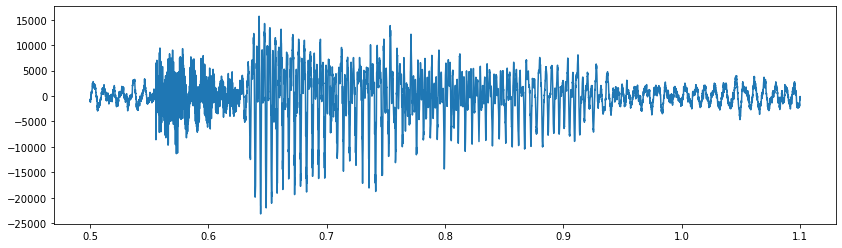

In [11]:
t = np.linspace(0,nsamps/fs,nsamps)
fig=plt.figure(figsize=(14,4))
ax=fig.subplots()
ax.plot(t[(0.5<t)&(t<1.1)],x[(0.5<t)&(t<1.1)])

Notice, in the waveform above, there is a periodic component in the "silence" before and after the speech begins.  There seem to be five or six periods in 0.05sec, so maybe the period is around 0.01sec, or around 100Hz.  We can listen to it using the following code:

In [12]:
import IPython.display as ipd
ipd.Audio(x, rate=fs)

## How to debug

Rather than printing every plot using separate blocks for both the distributed solution and your solution, instead, each of the following blocks will include lines to plot either one or the other.  In order to switch between your solution and the distributed solution, you'll need to comment out the other one.

In [13]:
import h5py
solutions = h5py.File('solutions.hdf5','r')

## Searching for the noise peaks

First, let's plot a spectrum, and try to find the frequencies of the noise components.

In [14]:
importlib.reload(submitted)
help(submitted.todo_spectrum)

Help on function todo_spectrum in module submitted:

todo_spectrum(x)
    Input:
    x (nsamps) - a waveform
    Output:
    spec (nsamps) - magnitude spectrum at nsamps frequencies between 0 and fs, not including fs.



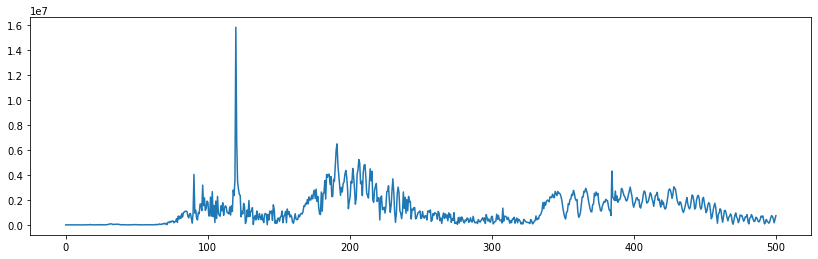

In [15]:
importlib.reload(submitted)
spec=submitted.todo_spectrum(x)
#spec = solutions['spec'][:]
f = np.linspace(0,fs,nsamps,endpoint=False)
fig=plt.figure(figsize=(14,4))
ax=fig.subplots()
ax.plot(f[f<500],spec[f<500])

* It looks like there's a huge power-line noise component at about 120Hz.  
* There doesn't seem to be any 60Hz component; the recording device seems to have filtered out all energy below about 80Hz.  
* There is also energy at about 180Hz, which might be the third harmonic of the power line noise, but it might also be the pitch of a female talker.  Let's leave that energy in the signal.
* Instead, let's eliminate three of the other small peaks that occur between 90Hz and 120Hz.
* We'll use the "todo_findpeak" function to find the frequencies of those peaks (if you've written it).

In [16]:
importlib.reload(submitted)
help(submitted.todo_findpeak)

Help on function todo_findpeak in module submitted:

todo_findpeak(spec, fs, flo, fhi)
    Input:
    spec (nsamps) - magnitude spectrum at nsamps frequencies between 0 and fs, not including fs.
    fs (scalar)  - sampling frequency
    flo (scalar) -  low end of the frequency range to search
    fhi (scalar) - high end of the frequency range to search
    Output:
    fpeak (scalar) - frequency of the highest-magnitude spectral sample, in Hertz



In [17]:
importlib.reload(submitted)
noise1 = submitted.todo_findpeak(spec, fs, 0, 100)
noise2 = submitted.todo_findpeak(spec, fs, noise1+1, 100)
noise3 = submitted.todo_findpeak(spec, fs, 100, 110)
noise4 = submitted.todo_findpeak(spec, fs, 100, 150)
freqs = np.array([noise1,noise2,noise3,noise4])
#freqs = solutions['freqs'][:]
print(freqs)

[ 90.28444206  96.42624084 103.18221949 119.7650762 ]


## Creating the notch filters

We'll create four notch filters: one for each of the frequencies we want to eliminate.  For each notch filter, we need to create zeros and poles for the Z transform, then convert them to filter coefficients.

In [18]:
importlib.reload(submitted)
help(submitted.todo_zeros)

Help on function todo_zeros in module submitted:

todo_zeros(freqs, fs)
    Input:
    freqs (nfreqs) - an array of nfreqs Hertz freqeuncies
    fs (scalar) - sampling frequency, in Hertz
    Output:
    z (2,nfreqs) - an array of complex zeros on the unit circle, in complex conjugate pairs



In [22]:
importlib.reload(submitted)
z = submitted.todo_zeros(freqs,fs)
#z = solutions['z'][:]
print(z)
print(solutions['z'][:])

<class 'numpy.ndarray'>
[[0.99937155+0.03544719j 0.99928315+0.03785745j 0.99917919+0.04050848j
  0.99889422+0.0470143j ]
 [0.99937155-0.03544719j 0.99928315-0.03785745j 0.99917919-0.04050848j
  0.99889422-0.0470143j ]]
[[0.99937155+0.03544719j 0.99928315+0.03785745j 0.99917919+0.04050848j
  0.99889422+0.0470143j ]
 [0.99937155-0.03544719j 0.99928315-0.03785745j 0.99917919-0.04050848j
  0.99889422-0.0470143j ]]


In [23]:
importlib.reload(submitted)
help(submitted.todo_poles)

Help on function todo_poles in module submitted:

todo_poles(z, BW, fs)
    Input: 
    z (2,nfreqs) - an array of complex zeros on the unit circle, in complex conjugate pairs
    BW (scalar) - desired bandwidth, in Hertz
    fs (scalar) - sampling frequency, in Hertz
    Output:
    p (2,nfreqs) - an array of complex poles with bandwidth BW, in complex conjugate pairs



In [24]:
importlib.reload(submitted)
p = submitted.todo_poles(z,20,fs)
#p = solutions['p'][:]
np.log(np.abs(p))

array([[-0.00392699, -0.00392699, -0.00392699, -0.00392699],
       [-0.00392699, -0.00392699, -0.00392699, -0.00392699]])

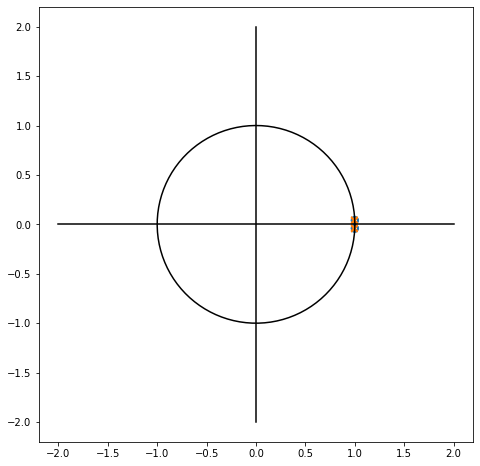

In [25]:
def pole_zero_plot(z,p):
    fig=plt.figure(figsize=(10,8))
    ax=fig.subplots()
    ax.plot([0,1e-6],[-2,2],'k-',[-2,2],[0,0],'k-')  # plot the axes
    omega = np.linspace(0,2*np.pi,200)
    ax.plot(np.cos(omega),np.sin(omega),'k-') # plot the unit circle
    ax.set_aspect('equal') # make it look like a circle
    zeromarker = matplotlib.markers.MarkerStyle(marker='o',fillstyle='none')
    polemarker = matplotlib.markers.MarkerStyle(marker='x',fillstyle='none')
    ax.scatter(x=np.real(z),y=np.imag(z),s=40,marker=zeromarker)
    ax.scatter(x=np.real(p),y=np.imag(p),s=40,marker=polemarker)
    return(ax)
ax=pole_zero_plot(z,p)


At that scale, the poles and zeros are all right on top of each other!  Let's try to zoom in.

(-0.05, 0.05)

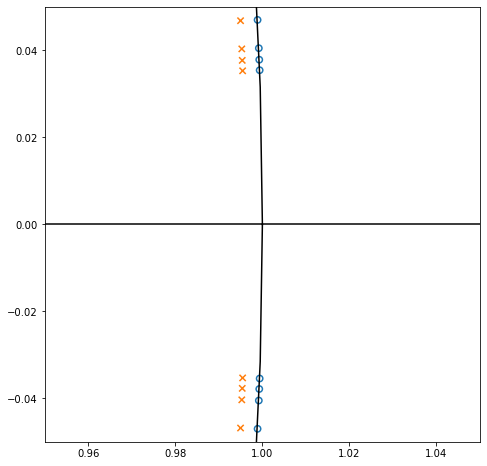

In [26]:
ax=pole_zero_plot(z,p)
ax.set_xlim([0.95,1.05])
ax.set_ylim([-0.05,0.05])


Finally, let's create the filter coefficients.  There are four filters, each of which has feedforward coefficients (b[:,k]) and feedback coefficients (a[:,k]).

In [27]:
importlib.reload(submitted)
help(submitted.todo_coefficients)

Help on function todo_coefficients in module submitted:

todo_coefficients(z)
    Input: 
    z (2,nfreqs) - an array of complex roots, in complex conjugate pairs
    Output:
    b (3,nfreqs) - an array of second-order polynomial coefficients, one per complex root pair



In [28]:
importlib.reload(submitted)
a = submitted.todo_coefficients(p)
#a = solutions['a'][:]
b = submitted.todo_coefficients(z)
#b = solutions['b'][:]
for whichfreq in range(4):
    print('For frequency',whichfreq,'numerator coefficients are',b[:,whichfreq])
    print('   and denominator coefficients are',a[:,whichfreq])

For frequency 0 numerator coefficients are [ 1.        -1.9987431  1.       ]
   and denominator coefficients are [ 1.         -1.99090945  0.99217678]
For frequency 1 numerator coefficients are [ 1.        -1.9985663  1.       ]
   and denominator coefficients are [ 1.         -1.99073334  0.99217678]
For frequency 2 numerator coefficients are [ 1.         -1.99835839  1.        ]
   and denominator coefficients are [ 1.         -1.99052624  0.99217678]
For frequency 3 numerator coefficients are [ 1.         -1.99778843  1.        ]
   and denominator coefficients are [ 1.         -1.98995852  0.99217678]


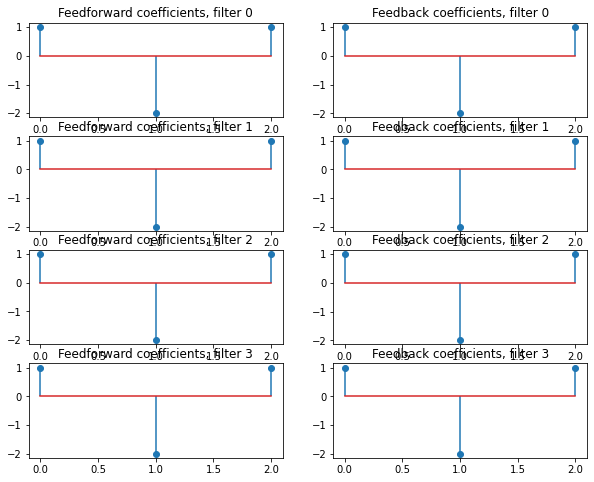

In [29]:
fig = plt.figure(figsize=(10,8))
axs=fig.subplots(len(freqs),2)
for row in range(len(freqs)):
    axs[row,0].stem(b[:,row],use_line_collection=True)
    axs[row,0].set_title('Feedforward coefficients, filter %d'%(row))
    axs[row,1].stem(a[:,row],use_line_collection=True)
    axs[row,1].set_title('Feedback coefficients, filter %d'%(row))

## Filtering out the noise

Let's plot the frequency response that we would get by running all four filters, one after the other.

In [30]:
importlib.reload(submitted)
help(submitted.todo_freqresponse)

Help on function todo_freqresponse in module submitted:

todo_freqresponse(a, b, nsamps)
    Input: 
    a (3) - feedback coefficients.  You may assume a[0]=1.
    b (3) - feedforward coefficients.  You may assume b[0]=1.
    nsamps (scalar) - number of samples of the frequency response to compute
    Output: 
    omega (nsamps) - frequencies linearly spaced between 0 and 2pi, not including 2pi.
    H (nsamps) - B(e^{jw})/A(e^{jw}) evaluated at the frequencies in the vector omega.



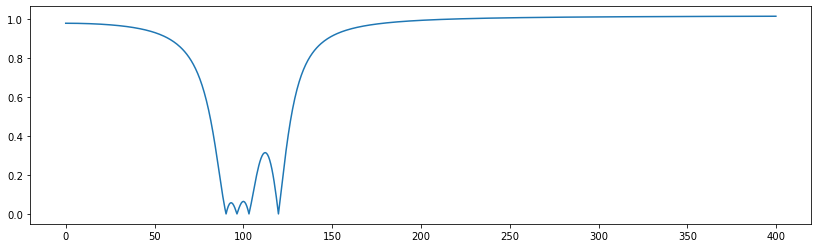

In [31]:
importlib.reload(submitted)
H = np.ones(nsamps,dtype='complex')
for k in range(len(freqs)):
    omega, Hnew = submitted.todo_freqresponse(a[:,k],b[:,k],nsamps)
    H *= Hnew
#H = solutions['H'][:]
fig=plt.figure(figsize=(14,4))
ax=fig.subplots()
plt.plot(f[f<400],np.abs(H[f<400]))

OK, now let's actually run all four filters, one after the other, and take a look at the resulting spectrum and signal, to see if the noise has been removed.

In [32]:
importlib.reload(submitted)
help(submitted.todo_filter)

Help on function todo_filter in module submitted:

todo_filter(x, a, b)
    Input: 
    a (3) - feedback coefficients.  You may assume a[0]=1.
    b (3) - feedforward coefficients.  You may assume b[0]=1.
    x (nsamps) - input waveform
    Output: 
    y (nsamps) - output after being filtered using B(z)/A(z)
      Assume that x[n]==0 for n<0.
      Do not generate samples of y[n] for n >= nsamps.



In [33]:
importlib.reload(submitted)
y = x
for k in range(len(freqs)):
    y = submitted.todo_filter(y,a[:,k],b[:,k])
#y = solutions['y']
print('Last five samples of y  are',y[-6:-1])

Last five samples of y  are [-9.03179256e+16 -1.56164465e+17 -2.21494554e+17 -2.86194682e+17
 -3.50152929e+17]


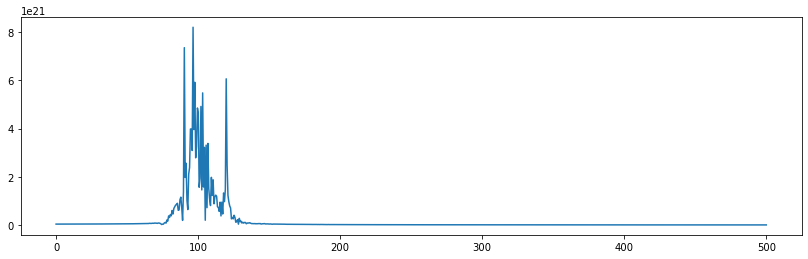

In [34]:
importlib.reload(submitted)
yspec=submitted.todo_spectrum(y)
fig=plt.figure(figsize=(14,4))
ax=fig.subplots()
ax.plot(f[f<500],yspec[f<500])


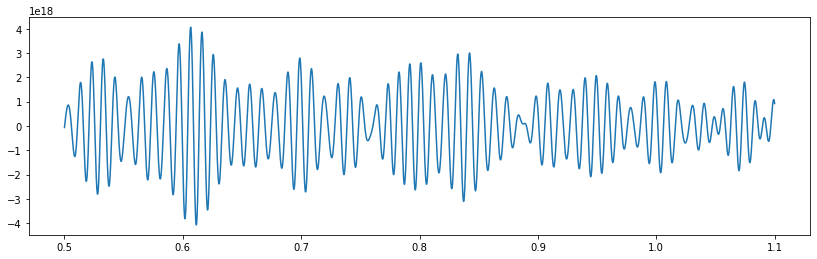

In [35]:
t = np.linspace(0,nsamps/fs,nsamps)
fig=plt.figure(figsize=(14,4))
ax=fig.subplots()
ax.plot(t[(0.5<t)&(t<1.1)],y[(0.5<t)&(t<1.1)])

## Conclusion

That's all! This is the basic technology behind utilities like `noiseremove,` in case you don't feel like doing it all by hand next time.